# KNN and ANN

## 3.1 KNN

In [1]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

from icecream import ic

In [2]:
def compute_distances(query, database, metric='euclidean'):
    if metric == 'euclidean':
        return euclidean_distances(query, database)
    else: # metric == 'cosine':
        return cosine_distances(query, database)

def knn(query, database, k=1, metric='euclidean'):
    distances = compute_distances(query, database, metric)
    return np.argsort(distances, axis=1)[:, :k]

def accuracy(predictions, true_labels):
    return np.mean(predictions == true_labels)

def mean_reciprocal_rank(ranks):
    return np.mean([1.0 / (rank + 1) for rank in ranks])

def precision_at_k(retrieved, relevant, k=100):
    return np.mean([len(set(r[:k]) & set(rel)) / k for r, rel in zip(retrieved, relevant)])

def hit_rate(retrieved, relevant):
    return np.mean([bool(set(r) & set(rel)) for r, rel in zip(retrieved, relevant)])


In [3]:
import torch

test_embeddings = torch.load("data/test_embeddings.pth").cpu().numpy()
test_labels = torch.load("data/test_labels.pth").cpu().numpy()
text_embeddings = torch.load("data/text_embedding.pth").cpu().numpy()
train_embeddings = torch.load("data/train_embeddings.pth").cpu().numpy()
train_labels = torch.load("data/train_labels.pth").cpu().numpy()


In [4]:
from collections import Counter

labels_semantics = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

def get_label_predictions(knn_values):
    index_to_labels = train_labels[knn_values]

    mapped = labels_semantics[np.array(index_to_labels)]

    most_common_labels = [Counter(row).most_common(1)[0][0] for row in mapped]
    
    return np.array(most_common_labels)

### Task 1: Classification

`Part A:` Classify each image in the test set using the labels of the k nearest neighbours from the train
set. Report the accuracy for 3 different values of k(1, 5, 10) and cosine and eucledian distance
metrics (2 Marks).

#### Subpart 1: Euclidean distances for k = 1, 5, 10

In [8]:
k_1_values_euclidean = knn(test_embeddings, train_embeddings, k = 1, metric = "euclidean")

k_5_values_euclidean = knn(test_embeddings, train_embeddings, k = 5, metric = "euclidean")

k_10_values_euclidean = knn(test_embeddings, train_embeddings, k = 10, metric = "euclidean")

k_x_euclidean = [k_1_values_euclidean, k_5_values_euclidean, k_10_values_euclidean]

In [6]:
print(k_1_values_euclidean.shape)
print(k_5_values_euclidean.shape)
print(k_10_values_euclidean.shape)

(10000, 1)
(10000, 5)
(10000, 10)


In [7]:
# for k_x_eu in k_x_euclidean:
print(get_label_predictions(k_1_values_euclidean))
print(get_label_predictions(k_5_values_euclidean))
print(get_label_predictions(k_10_values_euclidean))

['frog' 'ship' 'ship' ... 'dog' 'airplane' 'horse']
['frog' 'ship' 'ship' ... 'dog' 'airplane' 'horse']
['cat' 'ship' 'ship' ... 'dog' 'airplane' 'horse']


In [8]:
index_to_labels_k_1_eu = train_labels[k_1_values_euclidean]
index_to_labels_k_5_eu = train_labels[k_5_values_euclidean]
index_to_labels_k_10_eu = train_labels[k_10_values_euclidean]


most_common_labels_k_1_eu = np.array([Counter(row).most_common(1)[0][0] for row in index_to_labels_k_1_eu])
most_common_labels_k_5_eu = np.array([Counter(row).most_common(1)[0][0] for row in index_to_labels_k_5_eu])
most_common_labels_k_10_eu = np.array([Counter(row).most_common(1)[0][0] for row in index_to_labels_k_10_eu])

In [9]:
print("Accuracy for k = 1:", accuracy(most_common_labels_k_1_eu, test_labels) * 100, "%")
print("Accuracy for k = 5:", accuracy(most_common_labels_k_5_eu, test_labels)* 100, "%")
print("Accuracy for k = 10:", accuracy(most_common_labels_k_10_eu, test_labels)* 100, "%")

Accuracy for k = 1: 90.48 %
Accuracy for k = 5: 91.9 %
Accuracy for k = 10: 92.07 %


In [ ]:
k_1_values_cosine = knn(test_embeddings, train_embeddings, k = 1, metric = "cosine")

In [10]:
k_1_values_cosine = knn(test_embeddings, train_embeddings, k = 1, metric = "cosine")

k_5_values_cosine = knn(test_embeddings, train_embeddings, k = 5, metric = "cosine")

k_10_values_cosine = knn(test_embeddings, train_embeddings, k = 10, metric = "cosine")

k_x_cosine = [k_1_values_cosine, k_5_values_cosine, k_10_values_cosine]

: 

`Part B:` Instead of using the train set to predict the labels, now use the text embeddings to predict the
labels. Using k = 1, get the text embedding closest to each image and predict the accuracy (2
Marks)

In [10]:
distances_text = compute_distances(test_embeddings, text_embeddings, metric = "euclidean")
k_1_values_text = knn(test_embeddings, text_embeddings, k = 1, metric = "euclidean")

In [49]:
mapped_text = labels_semantics[np.array(k_1_values_text)]

In [22]:
np.array(k_1_values_text)

k_1_values_text.flatten()

array([3, 8, 8, ..., 5, 0, 7])

In [17]:
test_labels

array([3, 8, 8, ..., 5, 1, 7])

In [51]:
mapped_text

array([['cat'],
       ['ship'],
       ['ship'],
       ...,
       ['dog'],
       ['airplane'],
       ['horse']], dtype='<U10')

Accuracy

In [25]:
print("Accuracy =", accuracy(k_1_values_text.flatten(), test_labels) * 100, "%")


Accuracy = 87.81 %


#### Task 2: Retreival

`Part A:` Text to Image Retrieval: For each text embedding retrieve the 100 nearest embeddings from the
train set and report the 3 metrics: Mean reciprocal rank, precision@100 and hit rate. (2 Marks)

In [26]:
text_to_image = knn(text_embeddings, train_embeddings, k=100, metric="euclidean")

In [28]:
text_to_image

array([[30604, 25082,  5322, 20539, 35283, 47220,  4410, 35873, 27324,
        10577, 29341, 10486,  9077, 36427, 47379,  7528, 37032,  2403,
        36289, 16497, 23791, 17154,  9657, 19529, 31506, 10741, 24745,
        48119, 26144,  3548, 46303, 40635, 11812, 47676, 49863, 41821,
        38980, 28401,  1428, 13069, 24587, 19082, 44165, 13841, 18578,
        43628,  7095, 32109, 36573, 45507, 16785, 22080, 29844, 44082,
        13334, 43475, 44609, 32602, 13835, 13260, 11838, 47104, 48869,
          457, 40733, 46770, 17355,  2006, 10548, 22308, 30667, 10202,
         6640, 12469, 19277, 36858, 44257, 38185,  7328, 28302, 42288,
        46725, 44743, 21633, 37504,  7663, 30914, 41073, 23805, 24325,
        16734,  4540, 30959,   733,  5414, 47042, 26776, 35149, 39995,
        30971],
       [34163, 24486, 18639, 10832, 25061,  3142, 24417, 43251,  1029,
        18625, 26141, 10110, 40265,  8729,  3620, 30696, 10564,    64,
        35674, 48962,  7597, 39911, 26576, 20119,  6630,  551

`Part B:` Image to Image Retrieval: For each test embedding retrieve the 100 nearest embeddings from
train set and report the metrics mentioned above. (2 Marks)

In [ ]:
image_to_image = knn(test_embeddings, train_embeddings, k = 100, metric = "euclidean")

## 3.2 Locally Sensitive Hashing

#### `Task 1:` Implement LSH following the article linked above using random hyperplanes.

In [59]:
import numpy as np
import matplotlib.pyplot as plt

In [61]:
class LSH:
    def __init__(self, num_hyperplanes, dim):
        self.num_hyperplanes = num_hyperplanes
        self.dim = dim
        self.hyperplanes = np.random.randn(num_hyperplanes, dim)
        self.buckets = dict()

    def hash_vector(self, vec):
        return tuple((vec @ self.hyperplanes.T) > 0)

    def insert(self, vec, index):
        hash_key = self.hash_vector(vec)

        if hash_key not in list(self.buckets.keys()):
            self.buckets[hash_key] = []
        self.buckets[hash_key].append(index)

    def query(self, vec, k):
        hash_key = self.hash_vector(vec)
        candidates = self.buckets.get(hash_key, [])

        # there could be too many, so..
        if len(candidates) >= k:
            return np.random.choice(candidates, k, replace=False)
        
        all_candidates = list(candidates)
        for key, indices in self.buckets.items():
            if len(all_candidates) >= k:
                break
            all_candidates.extend(indices)
        
        return np.array(all_candidates[:k])

#### `Task 2:` Plot histograms showing frequency of samples in each bucket. Do this for different number of hyperplanes. What problems do you notice here?

In [62]:
import torch

test_embeddings = torch.load("data/test_embeddings.pth").cpu().numpy()
test_labels = torch.load("data/test_labels.pth").cpu().numpy()
text_embeddings = torch.load("data/text_embedding.pth").cpu().numpy()
train_embeddings = torch.load("data/train_embeddings.pth").cpu().numpy()

In [63]:
n, d = train_embeddings.shape
num_hyperplanes_list = [5, 10, 20, 50]

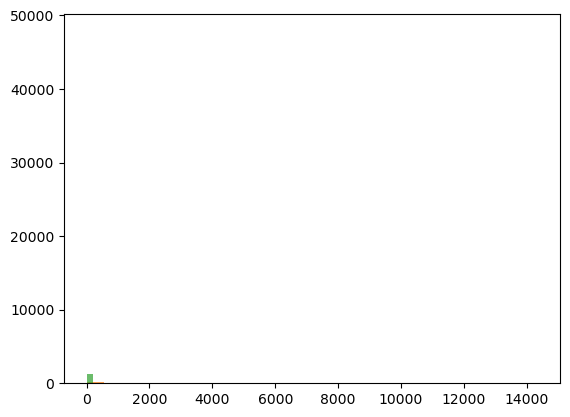

In [64]:
for num_hyperplanes in num_hyperplanes_list:
    lsh = LSH(num_hyperplanes, d)
    
    for idx, vec in enumerate(train_embeddings):
        lsh.insert(vec, idx)
    
    bucket_sizes = [len(v) for v in lsh.buckets.values()]
    plt.hist(bucket_sizes, bins=20, alpha=0.7, label=f'{num_hyperplanes} hyperplanes')

Problems that I notice here:

fill this ------------------------------------------------------------------------->>>>>>>>>>>>>>>>>>>>>>>

#### `Task 3:` Perform image to image retrieval for your choice of k and report metrics mentioned in the previous section.

/tmp/ipykernel_39275/1927524200.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


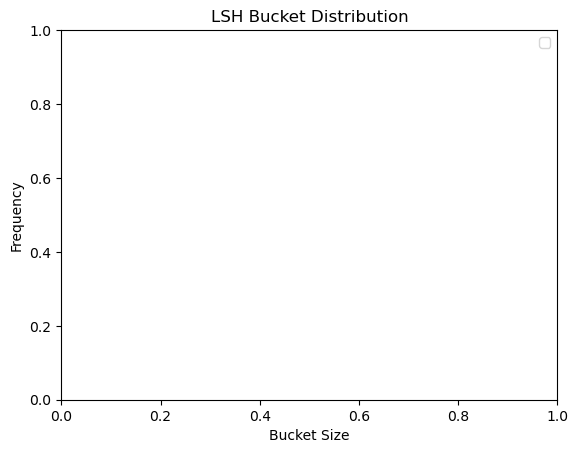

Retrieved Neighbors for Test Image: [0 0 1 2 3]


In [65]:
plt.xlabel('Bucket Size')
plt.ylabel('Frequency')
plt.legend()
plt.title('LSH Bucket Distribution')
plt.show()

test_index = 0
retrieved_indices = lsh.query(train_embeddings[test_index], k=5)

print("Retrieved Neighbors for Test Image:", retrieved_indices)

#### `Task 4:` How do these metrics change, on changing the number of hyperplanes, mention possible reasons for these.

## 3.3 IVF

#### `Task 1`: Implement IVF from scratch. Use Kmeans algorithm for clustering. Since the dataset has 10 classes one can assign clusters as 10 but you are free to experiment.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

class IVF:
    def __init__(self, k=10):
        self.k = k
        self.kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        self.inverted_index = {}
    
    def fit(self, data):

        self.kmeans.fit(data)
        labels = self.kmeans.labels_
        self.inverted_index = {i: [] for i in range(self.k)}
        
        for i, label in enumerate(labels):
            self.inverted_index[label].append(data[i])
        
        for key in self.inverted_index:
            self.inverted_index[key] = np.array(self.inverted_index[key])
    
    def search(self, query, nprobe=1, top_k=5):

        centroids = self.kmeans.cluster_centers_
        dists = cdist([query], centroids, metric='euclidean')[0]
        closest_clusters = np.argsort(dists)[:nprobe]
        
        candidates = []
        comparisons = 0
        
        for cluster in closest_clusters:
            cluster_points = self.inverted_index.get(cluster, [])
            candidates.extend(cluster_points)
            comparisons += len(cluster_points)
        
        candidates = np.array(candidates)
        if len(candidates) == 0:
            return [], comparisons
        

        distances = cdist([query], candidates, metric='euclidean')[0]
        nearest_indices = np.argsort(distances)[:top_k]
        
        return [candidates[i] for i in nearest_indices], comparisons

    def image_to_image_retrieval(self, test_embeddings, top_k=100, nprobe=5):

        all_retrieved = []
        all_comparisons = []
        
        for test_embedding in test_embeddings:
            retrieved, comparisons = self.search(test_embedding, nprobe=nprobe, top_k=top_k)
            all_retrieved.append(retrieved)
            all_comparisons.append(comparisons)
        
        return all_retrieved, all_comparisons

    def plot_comparisons_vs_nprobe(self, query, max_nprobe=10, top_k=5):
        comparisons = []
        for nprobe in range(1, max_nprobe + 1):
            _, total_comparisons = self.search(query, nprobe=nprobe, top_k=top_k)
            comparisons.append(total_comparisons)
        
        plt.plot(range(1, max_nprobe + 1), comparisons)
        plt.xlabel('nprobe')
        plt.ylabel('Total Comparisons')
        plt.title('Comparisons vs. nprobe')
        plt.show()

    def plot_cluster_distribution(self):

        cluster_sizes = [len(self.inverted_index[i]) for i in range(self.k)]
        plt.bar(range(self.k), cluster_sizes)
        plt.xlabel("Cluster ID")
        plt.ylabel("Number of Points")
        plt.title("Cluster Distribution")
        plt.show()

#### `Task 2`: Perform image to image retrieval again and report the metrics for different value of nprobe.

In [7]:
ivf = IVF(k=10)
ivf.fit(train_embeddings)

In [8]:
retrieved_images, comparisons = ivf.image_to_image_retrieval(test_embeddings, top_k=10, nprobe=2)

: 

#### `Task 3`: Plot the number of points in each cluster. Plot the average number of comparisons done for each query vs nprobe

## 3.4 Analysis